In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import math
import re

In [2]:
# Determine the absolute path to the src directory (one level up from notebooks)
module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
import plotting
import utils

In [3]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
RUNS_FOLDER = os.path.join(ROOT_FOLDER, "runs")
SINGLE_RUNS_FOLDER = os.path.join(RUNS_FOLDER, "single_runs")
BATCH_RUNS_FOLDER = os.path.join(RUNS_FOLDER, "batch_runs")

In [4]:
# Setup the folders to explore and their display name
folder1 = os.path.join(BATCH_RUNS_FOLDER, "1_GTSEP_v0-No name-Feb18_Tue_h08")
folder2 = os.path.join(BATCH_RUNS_FOLDER, "2_GTSEP_v1-No name-Feb18_Tue_h08")
results_folders_to_explore = [folder1, folder2,]
display_names = ["128 Model v0", "128 Model v1"]
MAX_COLUMNS = 2

# Alternatively explore all folders in a batch directory

## Figures

Showing: Grid-Related Figures


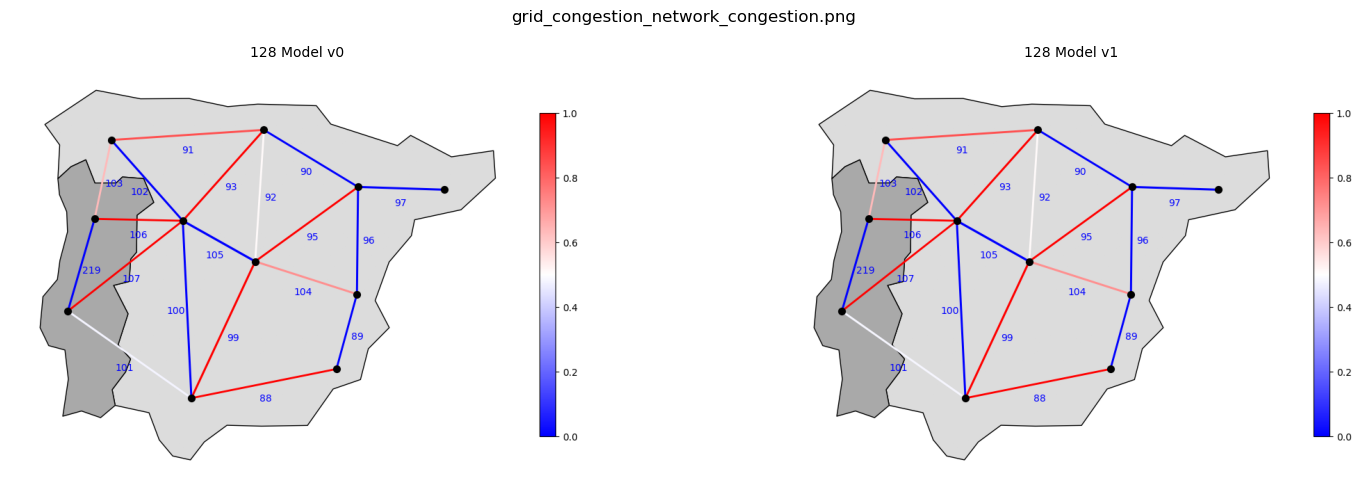

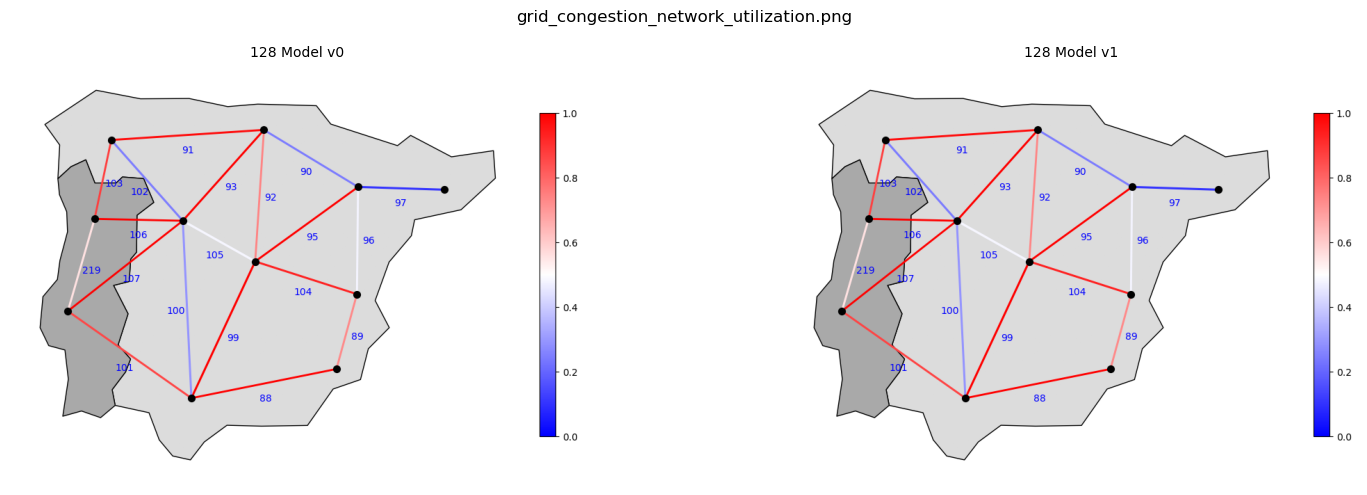

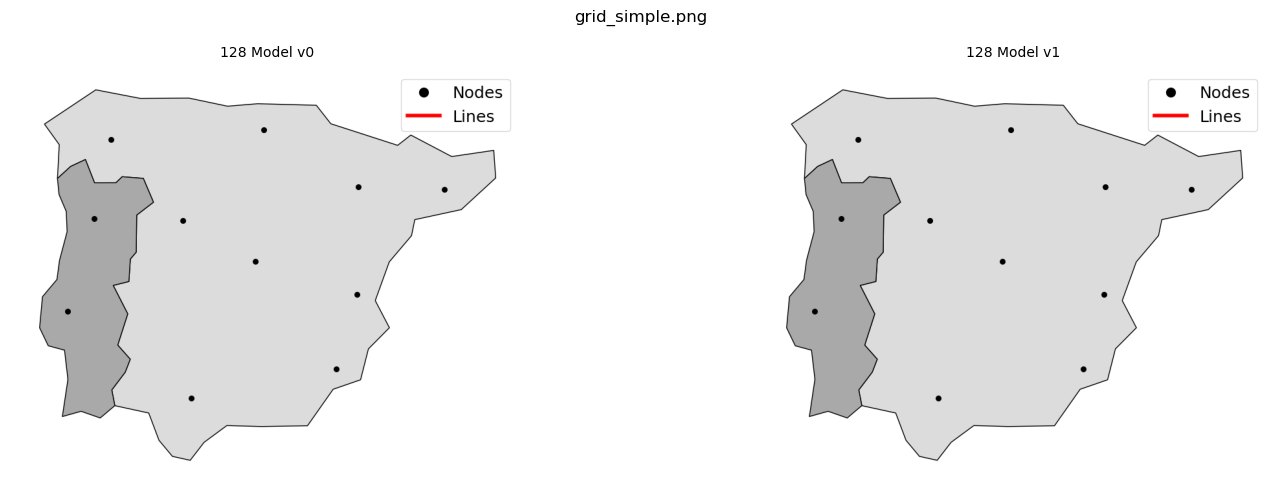

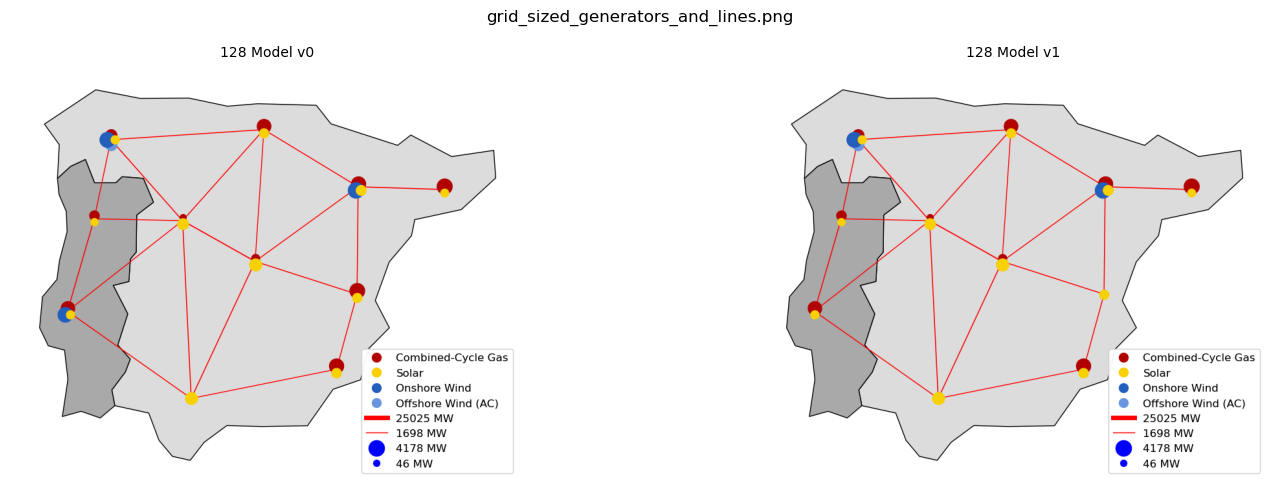

Showing: Bar Figures


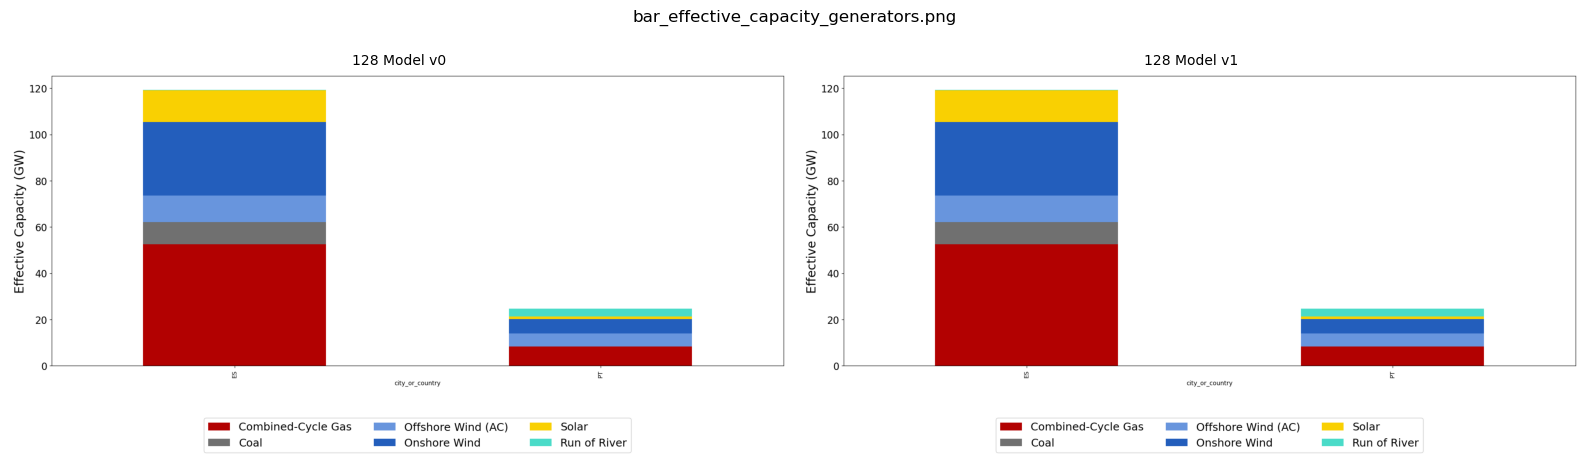

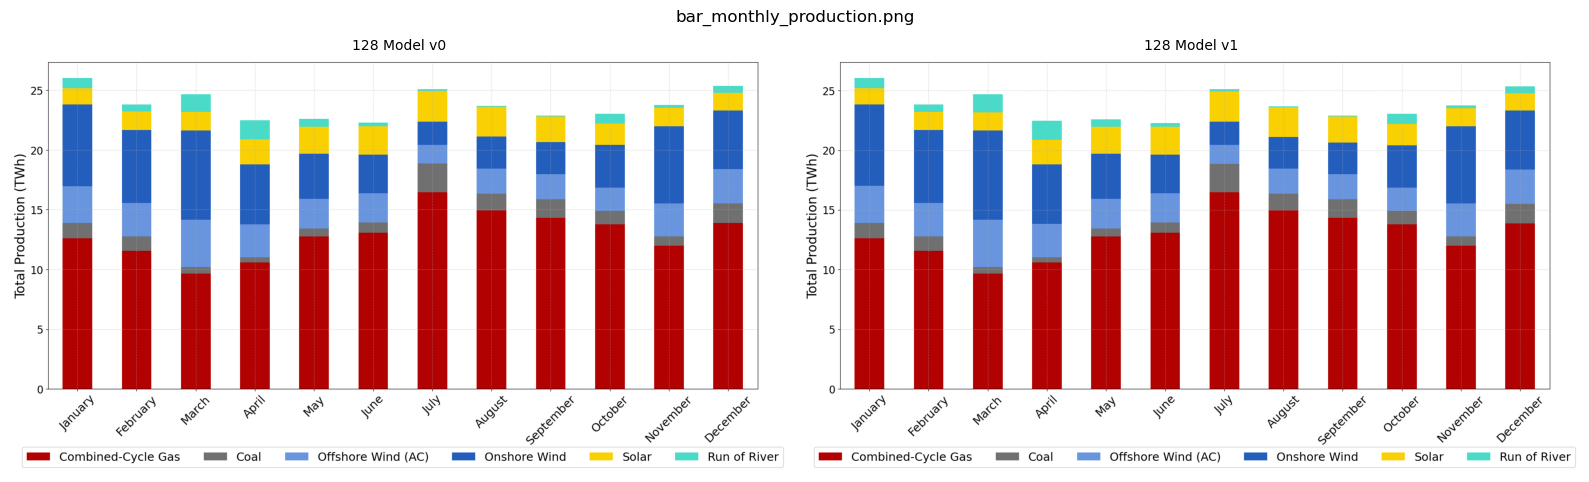

Showing: Battery - General Figures


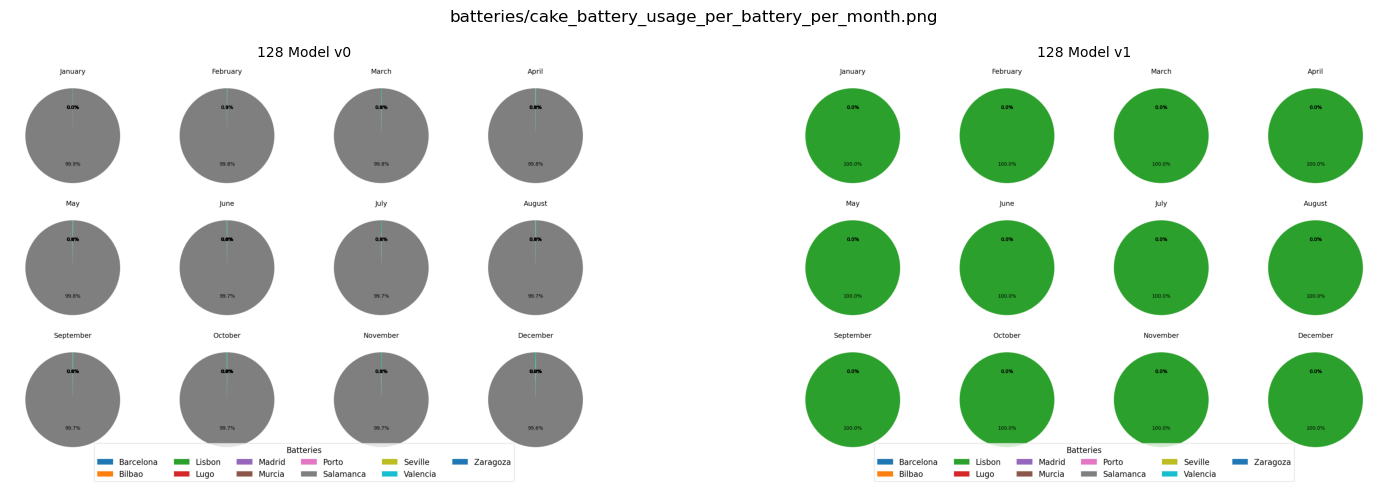

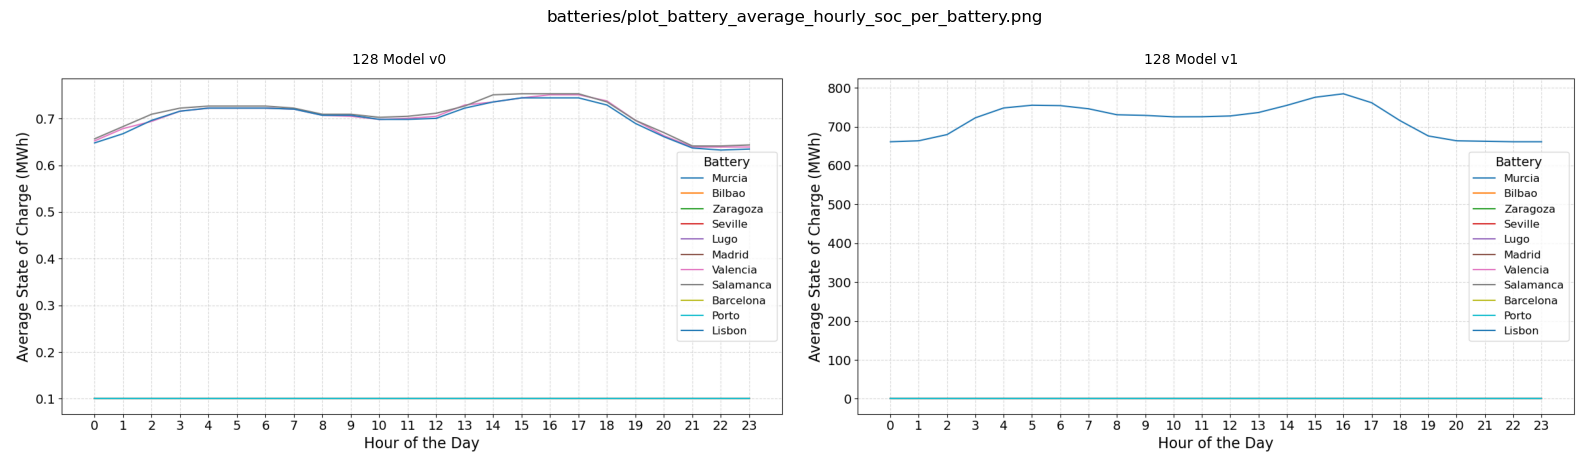

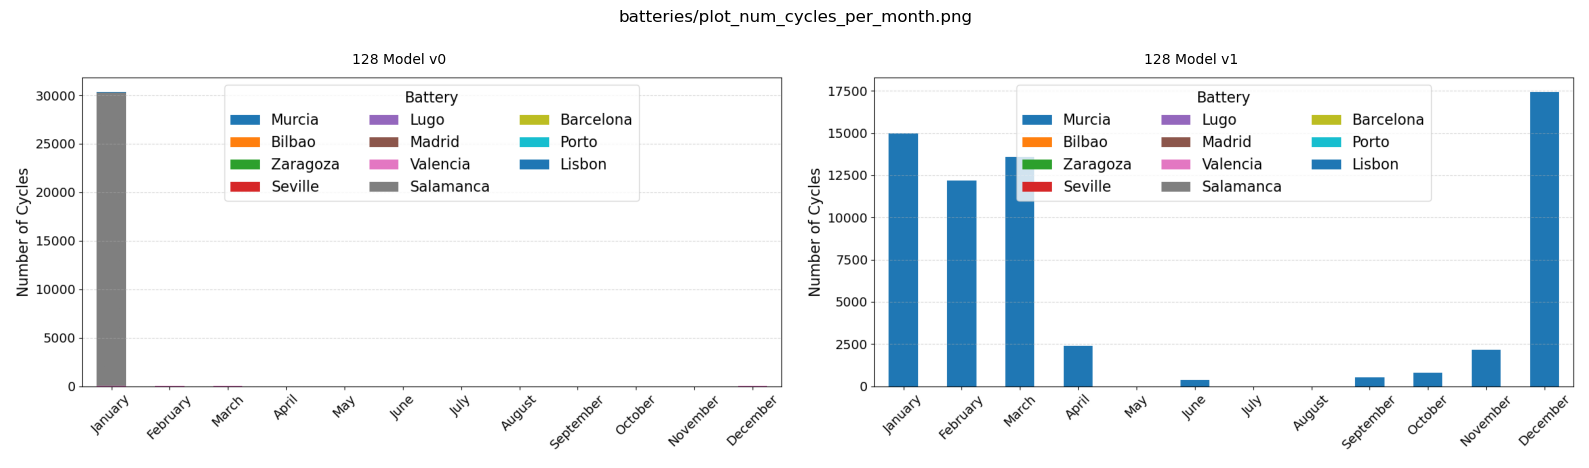

Showing: Remaining Figures
No images found for Remaining Figures.


In [5]:
def categorize_png_files(folder):
    figures_path = os.path.join(folder, "results", "figures")
    categorized_files = {
        "grid": [],
        "bar": [],
        "battery_general": [],
        "battery_hourly_soc": [],
        "battery_city_soc": [],
        "remaining": []
    }

    for root, _, files in os.walk(figures_path):
        for file in files:
            if file.endswith(".png"):
                relative_path = os.path.relpath(os.path.join(root, file), figures_path)
                
                # Normalize to use forward slashes for regex compatibility
                relative_path = relative_path.replace("\\", "/")  

                # Grid figures
                if relative_path.startswith("grid"):
                    categorized_files["grid"].append(relative_path)

                # Bar figures
                elif relative_path.startswith("bar"):
                    categorized_files["bar"].append(relative_path)

                # Battery subfolder
                elif "batteries" in relative_path:
                    if re.match(r"batteries/\d+_plot_battery_average_hourly_soc_month_", relative_path):
                        categorized_files["battery_hourly_soc"].append(relative_path)
                    elif re.match(r"batteries/[A-Za-z]+_plot_battery_average_hourly_soc_by_month_", relative_path):
                        categorized_files["battery_city_soc"].append(relative_path)
                    else:
                        categorized_files["battery_general"].append(relative_path)

                # Remaining figures
                else:
                    categorized_files["remaining"].append(relative_path)
    
    return categorized_files

# Get categorized PNG files from the first folder
reference_folder = results_folders_to_explore[0]
png_categories = categorize_png_files(reference_folder)

# Function to display grouped images
def display_images(image_group, title):
    print("=" * 80)
    print(f"Showing: {title}")
    print("=" * 80)

    if not image_group:
        print(f"No images found for {title}.")
        return

    num_folders = len(results_folders_to_explore)
    num_rows = math.ceil(num_folders / MAX_COLUMNS)  # Dynamically calculate number of rows

    for png_file in image_group:
        fig, axes = plt.subplots(num_rows, MAX_COLUMNS, figsize=(8 * MAX_COLUMNS, 5 * num_rows))

        # Ensure axes is always a 2D list for easy indexing
        if num_rows == 1:
            axes = [axes]  # Convert to list of lists for consistency
        if MAX_COLUMNS == 1:
            axes = [[ax] for ax in axes]  # Ensure row-based structure if only one column
        
        # Flatten for easier iteration
        axes = [ax for row in axes for ax in row]  
        
        for idx, (folder, name) in enumerate(zip(results_folders_to_explore, display_names)):
            img_path = os.path.join(folder, "results", "figures", png_file)
            
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                axes[idx].imshow(img)
                axes[idx].axis("off")
                axes[idx].set_title(name, fontsize=10)
            else:
                axes[idx].set_visible(False)

        # Hide unused subplots
        for ax in axes[num_folders:]:  
            ax.set_visible(False)

        plt.suptitle(png_file, fontsize=12)
        plt.tight_layout()
        plt.show()

# Display images in the correct order
display_images(png_categories["grid"], "Grid-Related Figures")
display_images(png_categories["bar"], "Bar Figures")
display_images(png_categories["battery_general"], "Battery - General Figures")
# display_images(png_categories["battery_hourly_soc"], "Battery - Hourly SOC Figures")
# display_images(png_categories["battery_city_soc"], "Battery - City SOC Figures")
display_images(png_categories["remaining"], "Remaining Figures")


## Tables

In [10]:
import os
import pandas as pd

# Dictionary to store lists of dataframes for each detected table
merged_tables = {}

# Scan all experiment folders for available tables
for folder, name in zip(results_folders_to_explore, display_names):
    tables_path = os.path.join(folder, "results", "tables")

    if os.path.exists(tables_path):
        table_files = [f for f in os.listdir(tables_path) if f.endswith(".csv")]

        for table_file in table_files:
            table_path = os.path.join(tables_path, table_file)
            table_file = table_file.replace(".csv", "")  # Remove file extension
            # Read CSV file
            df = pd.read_csv(table_path, index_col=0)

            # Add experiment name for comparison
            df.insert(0, "Experiment", name)

            # If dataframe has more than one row, apply multi-indexing
            if len(df) > 1:
                # If the first column is unnamed, assume it's a category like "Generator" and rename it
                if df.columns[1].startswith("Unnamed"):
                    df.rename(columns={df.columns[1]: "Category"}, inplace=True)
                
                # Set MultiIndex with Experiment and the first actual category column
                df.set_index(["Experiment", df.columns[1]], inplace=True)

            # Store the dataframe in the appropriate list
            if table_file not in merged_tables:
                merged_tables[table_file] = []
            merged_tables[table_file].append(df)

# Merge tables into final dataframes
final_merged_tables = {table: pd.concat(dataframes) for table, dataframes in merged_tables.items()}

# Display the merged tables
for table_name, df in final_merged_tables.items():
    print(f"\n=== {table_name} ===")
    display(df.head())  # Display first few rows for readability



=== table_branches_overview ===


,Experiment,new_branches,new_capacity_mw,util_old_%,util_combined_%,congestion_%
0,128 Model v0,0,0,59.891652,59.891652,48.338140
0,128 Model v1,0,0,59.892065,59.892065,48.350156



=== table_cost_breakdown ===


,Experiment,Building Generators (€),Building Transmission Lines (€),Building Batteries (€),Energy Production Cost (w/o Emissions) (€),CO2 Emissions Cost (€),Production Cost with Emissions (€),Load Shedding Cost (€),Curtailment Cost (€),Total Cost (€)
0,128 Model v0,7.510656e+08,0.0,59289.097339,6.458028e+09,3.045162e+09,9.503190e+09,1.064668e+08,0.0,1.036078e+10
0,128 Model v1,7.167063e+08,0.0,19763.032446,6.463870e+09,3.048602e+09,9.512472e+09,1.014672e+08,0.0,1.033067e+10



=== table_generators_overview ===


Potential Generators     Capacity  \
Experiment   Built Generators                                      
128 Model v0 10.0                                11  4329.120125   
             1.0                                  9   363.818370   
             3.0                                 11  1716.455616   
             11.0                                11  2541.403855   
             NaN                                  5     0.000000   

                               Potential Capacity  Utilization rate (%)  \
Experiment   Built Generators                                             
128 Model v0 10.0                     6090.066400             51.079040   
             1.0                      2746.930444             25.051028   
             3.0                      6407.900669             18.509989   
             11.0                     2541.403855             17.179736   
             NaN                       947.878697             33.304062   

                               Max utilization rate (%)  
Experiment   Built Generators                            
128 Model v0 10.0                            100.000000  
             1.0                              25.437235  
             3.0                              18.772328  
             11.0                             17.327553  
             NaN                             100.000000


=== table_generators_production_breakdown ===


New Production [MW]  Old Production [MW]  \
Experiment   Total Production [MW]                                             
128 Model v0 1.556215e+08                  2.694775e+07         1.286737e+08   
             1.382688e+07                  0.000000e+00         1.382688e+07   
             3.093867e+07                  1.144606e+06         2.979407e+07   
             5.473444e+07                  3.625537e+06         5.110891e+07   
             2.314548e+07                  3.857581e+06         1.928790e+07   

                                    Total Production Cost [€]  \
Experiment   Total Production [MW]                              
128 Model v0 1.556215e+08                        6.066636e+09   
             1.382688e+07                        3.898760e+08   
             3.093867e+07                        4.640801e+05   
             5.473444e+07                        8.210167e+05   
             2.314548e+07                        2.314548e+05   

                                    Cost of Buildout [€]  \
Experiment   Total Production [MW]                         
128 Model v0 1.556215e+08                   4.287029e+08   
             1.382688e+07                   0.000000e+00   
             3.093867e+07                   6.695623e+07   
             5.473444e+07                   1.649272e+08   
             2.314548e+07                   9.047924e+07   

                                    Marginal Cost [€/MWh]  \
Experiment   Total Production [MW]                          
128 Model v0 1.556215e+08                       40.520397   
             1.382688e+07                       28.196970   
             3.093867e+07                        0.015000   
             5.473444e+07                        0.015000   
             2.314548e+07                        0.010000   

                                    CO2 Emission Intensity [ton/MWh]  \
Experiment   Total Production [MW]                                     
128 Model v0 1.556215e+08                                       0.20   
             1.382688e+07                                       0.34   
             3.093867e+07                                       0.00   
             5.473444e+07                                       0.00   
             2.314548e+07                                       0.00   

                                    Total Production Cost [€] old  \
Experiment   Total Production [MW]                                  
128 Model v0 1.556215e+08                            6.305845e+09   
             1.382688e+07                            3.898760e+08   
             3.093867e+07                            4.640801e+05   
             5.473444e+07                            8.210167e+05   
             2.314548e+07                            2.314548e+05   

                                    Total CO2 Emissions [ton]  \
Experiment   Total Production [MW]                              
128 Model v0 1.556215e+08                        3.112430e+07   
             1.382688e+07                        4.701138e+06   
             3.093867e+07                        0.000000e+00   
             5.473444e+07                        0.000000e+00   
             2.314548e+07                        0.000000e+00   

                                    Total CO2 Cost [€]  \
Experiment   Total Production [MW]                       
128 Model v0 1.556215e+08                 2.645565e+09   
             1.382688e+07                 3.995967e+08   
             3.093867e+07                 0.000000e+00   
             5.473444e+07                 0.000000e+00   
             2.314548e+07                 0.000000e+00   

                                    Total Production Cost With Emissions [€]  \
Experiment   Total Production [MW]                                             
128 Model v0 1.556215e+08                                       8.712201e+09   
             1.382688e+07                                       7.894727e+08  


=== table_macro_results ===


,Experiment,Objective Value (Billion Euro),Generators Built,Potential Generators,Total Generator Capacity (MW),Transmission Lines Expanded,Potential Transmission Lines,Total Transmission Capacity (MW),Batteries Built,Potential Batteries,Total Battery Energy Capacity (MWh),Total Battery Power Capacity (MW),Total Load Shedding (MWh),Total Curtailment (MWh)
0,128 Model v0,10.360782,50.0,51.0,8950.797966,0.0,19.0,0.0,3.0,11,600000.000000,300000.000000,16766.422503,0.0
0,128 Model v1,10.357956,50.0,51.0,8600.437975,0.0,19.0,0.0,1.0,11,2487.474039,1243.737019,15979.082114,0.0


In [7]:
final_merged_tables.keys()

dict_keys(['table_branches_overview', 'table_cost_breakdown', 'table_generators_overview', 'table_generators_production_breakdown', 'table_macro_results'])

In [8]:
final_merged_tables["table_generators_overview"]

,Experiment,Unnamed: 0,Built Generators,Potential Generators,Capacity,Potential Capacity,Utilization rate (%),Max utilization rate (%)
0,128 Model v0,CCGT,10.0,11,4329.120125,6090.066400,51.079040,100.000000
1,128 Model v0,offwind-ac,1.0,9,363.818370,2746.930444,25.051028,25.437235
2,128 Model v0,onwind,3.0,11,1716.455616,6407.900669,18.509989,18.772328
3,128 Model v0,solar,11.0,11,2541.403855,2541.403855,17.179736,17.327553
4,128 Model v0,coal,NaN,5,0.000000,947.878697,33.304062,100.000000
5,128 Model v0,ror,NaN,4,0.000000,557.101650,30.597280,30.597381
6,128 Model v1,CCGT,9.0,11,4093.015825,6090.066400,51.470629,100.000000
7,128 Model v1,offwind-ac,1.0,9,363.818370,2746.930444,25.061040,25.437235
8,128 Model v1,onwind,2.0,11,1602.199925,6407.900669,18.521829,18.768421
9,128 Model v1,solar,11.0,11,2541.403855,2541.403855,17.179736,17.327553


In [16]:
def print_all_csv_tables(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                print(f"=== {file} ===")
                df = pd.read_csv(os.path.join(root, file)).reset_index(drop=True)
                display(df.head())

In [19]:
print_all_csv_tables(os.path.join(folder1, "results","tables"))

=== table_branches_overview.csv ===


,Unnamed: 0,new_branches,new_capacity_mw,util_old_%,util_combined_%,congestion_%
0,0,0,0,59.891652,59.891652,48.33814


=== table_cost_breakdown.csv ===


,Unnamed: 0,Building Generators (€),Building Transmission Lines (€),Building Batteries (€),Energy Production Cost (w/o Emissions) (€),CO2 Emissions Cost (€),Production Cost with Emissions (€),Load Shedding Cost (€),Curtailment Cost (€),Total Cost (€)
0,0,7.510656e+08,0.0,59289.097339,6.458028e+09,3.045162e+09,9.503190e+09,1.064668e+08,0.0,1.036078e+10


=== table_generators_overview.csv ===


,Unnamed: 0,Built Generators,Potential Generators,Capacity,Potential Capacity,Utilization rate (%),Max utilization rate (%)
0,CCGT,10.0,11,4329.120125,6090.066400,51.079040,100.000000
1,offwind-ac,1.0,9,363.818370,2746.930444,25.051028,25.437235
2,onwind,3.0,11,1716.455616,6407.900669,18.509989,18.772328
3,solar,11.0,11,2541.403855,2541.403855,17.179736,17.327553
4,coal,NaN,5,0.000000,947.878697,33.304062,100.000000


=== table_generators_production_breakdown.csv ===


,carrier,Total Production [MW],New Production [MW],Old Production [MW],Total Production Cost [€],Cost of Buildout [€],Marginal Cost [€/MWh],CO2 Emission Intensity [ton/MWh],Total Production Cost [€] old,Total CO2 Emissions [ton],Total CO2 Cost [€],Total Production Cost With Emissions [€],Total Cost €
0,CCGT,1.556215e+08,2.694775e+07,1.286737e+08,6.066636e+09,4.287029e+08,40.520397,0.20,6.305845e+09,3.112430e+07,2.645565e+09,8.712201e+09,9.140904e+09
1,coal,1.382688e+07,0.000000e+00,1.382688e+07,3.898760e+08,0.000000e+00,28.196970,0.34,3.898760e+08,4.701138e+06,3.995967e+08,7.894727e+08,7.894727e+08
2,offwind-ac,3.093867e+07,1.144606e+06,2.979407e+07,4.640801e+05,6.695623e+07,0.015000,0.00,4.640801e+05,0.000000e+00,0.000000e+00,4.640801e+05,6.742031e+07
3,onwind,5.473444e+07,3.625537e+06,5.110891e+07,8.210167e+05,1.649272e+08,0.015000,0.00,8.210167e+05,0.000000e+00,0.000000e+00,8.210167e+05,1.657482e+08
4,solar,2.314548e+07,3.857581e+06,1.928790e+07,2.314548e+05,9.047924e+07,0.010000,0.00,2.314548e+05,0.000000e+00,0.000000e+00,2.314548e+05,9.071070e+07


=== table_macro_results.csv ===


,Unnamed: 0,Objective Value (Billion Euro),Generators Built,Potential Generators,Total Generator Capacity (MW),Transmission Lines Expanded,Potential Transmission Lines,Total Transmission Capacity (MW),Batteries Built,Potential Batteries,Total Battery Energy Capacity (MWh),Total Battery Power Capacity (MW),Total Load Shedding (MWh),Total Curtailment (MWh)
0,0,10.360782,50.0,51.0,8950.797966,0.0,19.0,0.0,3.0,11,600000.0,300000.0,16766.422503,0.0


In [ ]:
# Dictionary to store lists of dataframes for each detected table
merged_tables = {}

# Loop over each experiment folder
for folder, name in zip(results_folders_to_explore, display_names):
    tables_path = os.path.join(folder, "results", "tables")

    if os.path.exists(tables_path):
        # Get all CSV filenames in the tables folder
        table_files = [f for f in os.listdir(tables_path) if f.endswith(".csv")]

        for table_file in table_files:
            table_path = os.path.join(tables_path, table_file)
            table_key = table_file.replace(".csv", "")  # key without extension

            # First, read the CSV without specifying an index to count rows
            temp_df = pd.read_csv(table_path)

            if len(temp_df) > 1:
                # For tables with more than one row, we assume the CSV was saved with an index.
                # Read the CSV using the first column as the index.
                df = pd.read_csv(table_path, index_col=0)
                
                # Preserve the existing index name (if it’s None, set a default, e.g. "Category")
                existing_index_name = df.index.name if df.index.name is not None else "Category"
                
                # Create a new MultiIndex combining the experiment name and the existing index.
                new_index = pd.MultiIndex.from_arrays(
                    [[name] * len(df), df.index],
                    names=["Experiment", existing_index_name]
                )
                df.index = new_index

            else:
                # For single-row tables, there is no saved index.
                # Read the CSV normally and insert an "Experiment" column.
                df = temp_df.copy()
                df.insert(0, "Experiment", name)

            # Save the dataframe in the dictionary under its table key.
            if table_key not in merged_tables:
                merged_tables[table_key] = []
            merged_tables[table_key].append(df)

# Merge dataframes for each table type
final_merged_tables = {table: pd.concat(dfs) for table, dfs in merged_tables.items()}

# Display the merged tables (showing only the first few rows for brevity)
for table_name, df in final_merged_tables.items():
    print(f"\n=== {table_name} ===")
    print(df.head())
